In [1]:
%%capture
!pip install orange3
!pip install eli5
!pip install shap
!pip install pdpbox

In [7]:
from sklearn import datasets,model_selection
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from ipywidgets import interactive
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from IPython.display import SVG
from IPython.display import display                               
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost
from sklearn.metrics import classification_report
import eli5
from eli5.sklearn import PermutationImportance

In [3]:
breastCancer = datasets.load_breast_cancer()
X = breastCancer.data
y = breastCancer.target
target_names = breastCancer.target_names
feature_names = breastCancer.feature_names
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


White box - Logistic Regression

In [8]:
lin_model = LogisticRegression(solver="newton-cg",penalty='l2',max_iter=1000,C=100,random_state=0)
lin_model.fit(x_train, y_train)
predicted_train = lin_model.predict(x_train)
predicted_test = lin_model.predict(x_test)
predicted_proba_test = lin_model.predict_proba(x_test)
print("Logistic Regression Model Performance:")
print("Accuracy in Train Set",accuracy_score(y_train, predicted_train))
print("Accuracy in Test Set",accuracy_score(y_test, predicted_test))

Logistic Regression Model Performance:
Accuracy in Train Set 0.9899497487437185
Accuracy in Test Set 0.9707602339181286


  Global interpretation

Number of features: 30


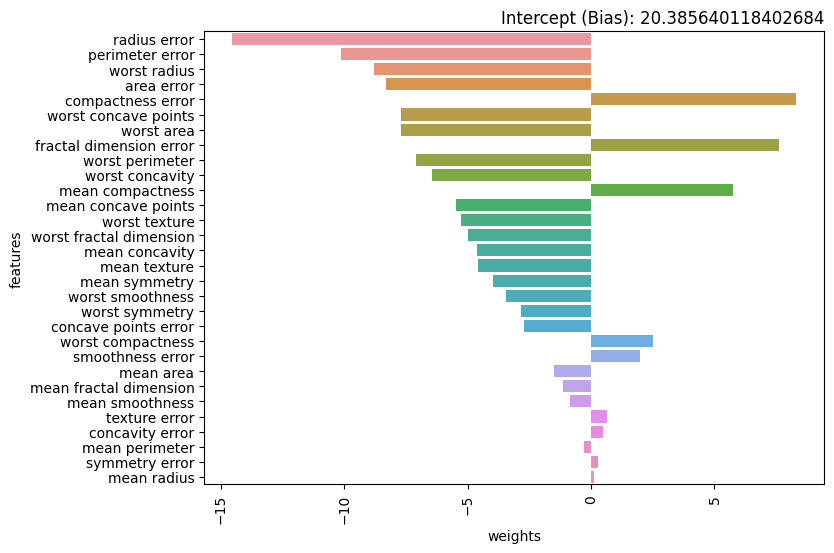

In [9]:
weights = lin_model.coef_
model_weights = pd.DataFrame({ 'features': list(feature_names),'weights': list(weights[0])})
model_weights = model_weights.reindex(model_weights['weights'].abs().sort_values(ascending=False).index) #Sort by absolute value
model_weights = model_weights[(model_weights["weights"] != 0)]    
print("Number of features:",len(model_weights.values))
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="weights", y="features", data=model_weights)
plt.title("Intercept (Bias): "+str(lin_model.intercept_[0]),loc='right')
plt.xticks(rotation=90)
plt.show()

Local Interpretation

In [10]:
def plot_sensor(instance=0):
  random_instance = x_test[instance]
  print("Original Class:",target_names[y_test[instance]]+", Predicted Class:",target_names[predicted_test[instance]],"with probability of",predicted_proba_test[instance][predicted_test[instance]])
  weights = lin_model.coef_
  summation = sum(weights[0]*random_instance)
  bias = lin_model.intercept_[0]
  res = ""
  if (summation + bias > 0):
    res = " > 0 -> 1"
  else:
    res = " <= 0 -> 0"
  print("Sum(weights*instance): "+str(summation)+" + Intercept (Bias): "+str(bias)+" = "+ str(summation+bias)+ res)
  model_weights = pd.DataFrame({ 'features': list(feature_names),'weights*values': list(weights[0]*random_instance)})
  #model_weights = model_weights.sort_values(by='weights*values', ascending=False)
  model_weights = model_weights.reindex(model_weights['weights*values'].abs().sort_values(ascending=False).index) #Sort by absolute value
  model_weights = model_weights[(model_weights["weights*values"] != 0)]    
  print("Number of features:",len(model_weights.values))
  plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
  sns.barplot(x="weights*values", y="features", data=model_weights)
  plt.xticks(rotation=90)
  plt.show()
inter=interactive(plot_sensor 
   , instance=(0,9))
display(inter)

interactive(children=(IntSlider(value=0, description='instance', max=9), Output()), _dom_classes=('widget-inte…

Black box - Random Forest


In [11]:
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print("Random Forests Performance:")
print(accuracy_score(y_test,y_pred))

Random Forests Performance:
0.9707602339181286


In [12]:
new_x_train = x_train
new_y_train = classifier.predict(x_train)

Global Surrogate Models

In [15]:
#Train decision tree as white box model
print("Decision Tree Explanator")
def plot_tree(depth=1):
    estimator = DecisionTreeClassifier(random_state = 0 
          , criterion = 'gini'
          , max_depth = depth)
    estimator.fit(new_x_train, new_y_train)
    graph = Source(export_graphviz(estimator
          , out_file=None
          , feature_names=feature_names
          , class_names=target_names
          , filled = True))
    print("Fidelity",accuracy_score(y_pred, estimator.predict(x_test)))
    print("Accuracy in new data")
    print(accuracy_score(y_test, estimator.predict(x_test)))
    #We could calculate R-square metric too!
    display(SVG(graph.pipe(format='svg')))
    return estimator
inter=interactive(plot_tree 
   , depth=(1,5))
display(inter)

Decision Tree Explanator


interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Local Surrogate Models

In [16]:
knnmodel = KNeighborsClassifier(n_neighbors=50, weights="distance", metric="minkowski", p=2)
knnmodel = knnmodel.fit(new_x_train, new_y_train)
print("Finding Neighbors of Instance...")
test_x = [x_test[0]]
ys = knnmodel.kneighbors(test_x, n_neighbors=50, return_distance=False) #Try for 100!
new_x_train2 = []
new_y_train2 = []
for i in ys[0]:
    new_x_train2.append(new_x_train[i])
    new_y_train2.append(new_y_train[i])

print("Decision Tree Explanator")
def plot_tree(depth=1):
    estimator = DecisionTreeClassifier(random_state = 0 
          , criterion = 'gini'
          , max_depth = depth)
    print("Creating Decision Tree for the Instance:")
    estimator.fit(new_x_train2, new_y_train2)
    print("Decision Tree Predicts and explains for Instance:" + str(estimator.predict(test_x)) + " and Random Forests predicted:" + str(classifier.predict(test_x)))
    fidelityPreds = estimator.predict(new_x_train2)
    print("Let's see fidelity",accuracy_score(new_y_train2,fidelityPreds))
    
    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=feature_names
      , class_names=target_names
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
    print("Lets find out the path for this specific instance!")
    for i in estimator.decision_path(test_x):
        print(i)
    return estimator
inter=interactive(plot_tree 
   , depth=(1,5))
display(inter)

Finding Neighbors of Instance...
Decision Tree Explanator


interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…